In [2]:
import os

import nibabel as nib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
import seaborn as sns

In [3]:
LABEL_NAME = {
    0: 'background',
    1: 'displaced',
    2: 'non-displaced',
    3: 'buckle',
    4: 'segmental',
    -1: 'undefined'
}


def get_frac_type(label):
    return LABEL_NAME[label]

rib_frac_types = {name: 0 for name in LABEL_NAME.values()}
rib_data = defaultdict(list)
nr_frac = defaultdict(int)

for index, row in pd.read_csv('train/ribfrac-train-info-1.csv').iterrows():
    rib_data[row[0]].append(row[2])
    nr_frac[row[0]] += 1
    if row[2] != 0:
        rib_frac_types[get_frac_type(row[2])] += 1
        
for index, row in pd.read_csv('train/ribfrac-train-info-2.csv').iterrows():
    rib_data[row[0]].append(row[2])
    nr_frac[row[0]] += 1
    if row[2] != 0:
        rib_frac_types[get_frac_type(row[2])] += 1
        
for index, row in pd.read_csv('train/ribfrac-val-info.csv').iterrows():
    rib_data[row[0]].append(row[2])
    nr_frac[row[0]] += 1
    if row[2] != 0:
        rib_frac_types[get_frac_type(row[2])] += 1
        
print(rib_data)
print(nr_frac)
#print(rib_frac_types)

total_rib_frac = sum(rib_frac_types.values())
avg_frac = total_rib_frac/len(nr_frac)
print('average fractures', avg_frac)
print('total fractures',total_rib_frac)

FileNotFoundError: [Errno 2] No such file or directory: 'train/ribfrac-train-info-1.csv'

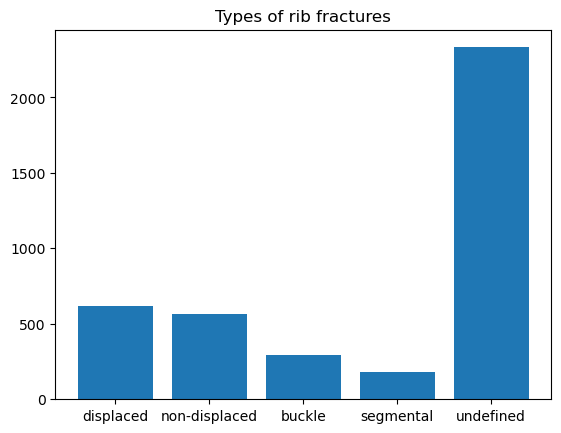

In [12]:
plt.bar(list(rib_frac_types.keys())[1:],list(rib_frac_types.values())[1:])
plt.title('Types of rib fractures')
plt.show()

In [24]:
def get_axis(scan, label, idx):
    min_x = -999
    max_x = -999
    min_y = -999
    max_y = -999
#     xs = []
#     ys = []
    for i, slice_ in enumerate(scan[idx[0]:idx[-1]+1]):
        #frac = np.where(slice_ == label, 1, 0)
        #xs.append(max(np.sum(frac, axis = 1)))
        #ys.append(max(np.sum(frac, axis = 0)))
        x, y = np.where(slice_ == label)
        min_x, max_x, min_y, max_y = np.min(x), np.max(x), np.min(y), np.max(y)
    if min_x == -999:
        print(len(scan), idx, scan)
    return min_x, max_x, min_y, max_y


def center_of_mass(crop_3d: np.array) -> tuple:
    """
    computes the center of mass of the given 3d volume (x,y,z).
    the provided 3d chunk has 1 (or mass M) for filled voxels and 0 if empty.
    the output is the index coordinates relative to the origin of the provided chunk.
    """
    x = np.arange(crop_3d.shape[0])
    y = np.arange(crop_3d.shape[1])
    z = np.arange(crop_3d.shape[2])
    vx, vy, vz = np.meshgrid(x, y, z, indexing='ij')
    r = np.vstack([vx.ravel(), vy.ravel(), vz.ravel()])
    m = crop_3d.reshape(1, -1)
    com = np.sum(r * m, axis=1) / np.sum(m)
    return com


def process_folder(folder_name, nr_frac, rib_data, data_root: str, csv_filename: str = "data_info.csv"):
    data = []
    set_ = (
        "train"
        if "train" in folder_name
        else "val"
        if "val" in folder_name
        else "test"
    )
    slice_amt = defaultdict(int)
    for filename in tqdm(
        os.listdir(os.path.join(data_root, folder_name))[2:], desc=folder_name
    ):
        f = os.path.join(data_root, folder_name, filename)
        if filename.endswith("label.nii.gz"):
            data_dev = []
            scan = nib.load(f).get_fdata().T.astype(float)
            slice_amt[filename] = len(scan)
            label_f = f.replace("image", "label")
            labels = nib.load(label_f).get_fdata().T.astype(int)
            for i, slice in enumerate(scan):
                unique_labels = np.unique(labels[i]).tolist()
                data_temp = [
                            os.path.join(folder_name, filename),
                            i,
                            set_,
                            unique_labels,
                            ]
                data_dev.append(data_temp)
                
            df_slice = pd.DataFrame(
            data_dev,
            columns=[
                "img_filename",
                "slice_idx",
                "set",
                "labels",
            ],
            )
            fn = filename.split('-')[0]
            frac_data = []
            for i in range(1,nr_frac[fn]):
                idx = []
                for ind in df_slice.index:
                    if i in df_slice['labels'][ind]:
                        idx.append(df_slice['slice_idx'][ind])
                if idx == []:
                    print(fn)
                    continue
                
                frac_type = get_frac_type(rib_data[fn][i])
                min_x, max_x, min_y, max_y = get_axis(scan, i, idx)
                min_z, max_z = idx[0], idx[-1]
                crop_3d = scan[idx[0]:idx[-1], min_x:max_x+1, min_y:max_y+1]  # (z, x, y)
                com_z, com_x, com_y = center_of_mass(crop_3d)  # com relative to chunk
                com_x += min_x
                com_y += min_y
                com_z += min_z
                scan_dim_z, scan_dim_x, scan_dim_y = scan.shape  # (z, x, y)
                
                data.append([
                    os.path.join(folder_name, fn+'fracture'+str(i)),  # img_filename
                    set_,  # set
                    #(idx[-1] + idx[0])/ 2,  # height
                    #size_x,  # size_x
                    #size_y,  # size_y
                    #idx[-1] - idx[0],  # size_z
                    #idx,  # slices
                    frac_type,
                    min_x,
                    max_x,
                    min_y,
                    max_y,
                    min_z,
                    max_z,
                    com_x,
                    com_y,
                    com_z,
                    scan_dim_x,
                    scan_dim_y,
                    scan_dim_z,
                ])

    df = pd.DataFrame(
        data,
        columns=[
            "img_filename",
            "set",
            #"height",
            #"size_x",
            #"size_y",
            #"size_z",
            #"slices",
            "frac_type",
            # bounding box limits (absolute pixel values)
            "min_x",
            "max_x",
            "min_y",
            "max_y",
            "min_z",
            "max_z",
            # center of mass of chunk (absolute pixel values)
            "com_x",
            "com_y",
            "com_z",
            # scan size (absolute pixel values)
            "scan_size_x",
            "scan_size_y",
            "scan_size_z",
        ],
    )
    # size of bounding box
    df['size_x'] = df['max_x'] - df['min_x']
    df['size_y'] = df['max_y'] - df['min_y']
    df['size_z'] = df['max_z'] - df['min_z']
    # center of bounding box
    df['loc_x'] = (df['max_x'] + df['min_x']) / 2
    df['loc_y'] = (df['max_y'] + df['min_y']) / 2
    df['loc_z'] = (df['max_z'] + df['min_z']) / 2
    # relative dimensions
    attrs = ['min', 'max', 'loc', 'com', 'size']
    axes = ['x', 'y', 'z']
    for attr in attrs:
        for axis in axes:
            abs_attr = attr + '_' + axis
            scan_size = 'scan_size_' + axis
            rel_attr = 'rel_' + abs_attr
            df[rel_attr] = df[abs_attr] / df[scan_size]
    return df,slice_amt

data,slice_amt = process_folder('train',nr_frac, rib_data,'')
print(slice_amt)
avg_slices = sum(slice_amt.values())/len(slice_amt)
print('average amount of slices:',avg_slices)
print('size of sections:',avg_slices/3)
high = avg_slices - avg_slices/3
low = high - avg_slices/3
print('definition fracture high height: >',high)
print('definition fracture mid height:',high,'<->',low)
print('definition fracture low height: <',low)

data['height_section'] = np.where(data['loc_z'] > high, 'high', 'mid')
data['height_section'] = np.where(data['loc_z'] < low, 'low', data['height_section'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3, ): print(data)

# plt.bar(data['height_section'])

train:  47%|██████████████████████████████████                                       | 392/840 [04:25<04:41,  1.59it/s]C:\Users\Martijn\AppData\Local\Temp\ipykernel_3916\1783878999.py:31: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(r * m, axis=1) / np.sum(m)
train:  47%|██████████████████████████████████▏                                      | 394/840 [04:26<04:46,  1.56it/s]

309 [179] [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


train:  52%|█████████████████████████████████████▋                                   | 434/840 [04:53<04:32,  1.49it/s]C:\Users\Martijn\AppData\Local\Temp\ipykernel_3916\1783878999.py:31: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(r * m, axis=1) / np.sum(m)
train:  52%|█████████████████████████████████████▉                                   | 436/840 [04:54<04:35,  1.47it/s]

363 [283] [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


train:  74%|██████████████████████████████████████████████████████▏                  | 624/840 [07:01<02:23,  1.51it/s]C:\Users\Martijn\AppData\Local\Temp\ipykernel_3916\1783878999.py:31: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(r * m, axis=1) / np.sum(m)
train:  75%|██████████████████████████████████████████████████████▍                  | 626/840 [07:03<02:31,  1.41it/s]

423 [222] [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


train:  90%|█████████████████████████████████████████████████████████████████▋       | 756/840 [08:31<00:50,  1.65it/s]C:\Users\Martijn\AppData\Local\Temp\ipykernel_3916\1783878999.py:31: RuntimeWarning: invalid value encountered in true_divide
  com = np.sum(r * m, axis=1) / np.sum(m)
train:  90%|█████████████████████████████████████████████████████████████████▊       | 758/840 [08:32<00:49,  1.65it/s]

353 [170] [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


train: 100%|█████████████████████████████████████████████████████████████████████████| 840/840 [09:28<00:00,  1.48it/s]


defaultdict(<class 'int'>, {'RibFrac1-label.nii.gz': 333, 'RibFrac10-label.nii.gz': 361, 'RibFrac100-label.nii.gz': 333, 'RibFrac101-label.nii.gz': 353, 'RibFrac102-label.nii.gz': 417, 'RibFrac103-label.nii.gz': 357, 'RibFrac104-label.nii.gz': 333, 'RibFrac105-label.nii.gz': 348, 'RibFrac106-label.nii.gz': 417, 'RibFrac107-label.nii.gz': 381, 'RibFrac108-label.nii.gz': 337, 'RibFrac109-label.nii.gz': 409, 'RibFrac11-label.nii.gz': 333, 'RibFrac110-label.nii.gz': 398, 'RibFrac111-label.nii.gz': 353, 'RibFrac112-label.nii.gz': 373, 'RibFrac113-label.nii.gz': 321, 'RibFrac114-label.nii.gz': 321, 'RibFrac115-label.nii.gz': 325, 'RibFrac116-label.nii.gz': 422, 'RibFrac117-label.nii.gz': 413, 'RibFrac118-label.nii.gz': 422, 'RibFrac119-label.nii.gz': 279, 'RibFrac12-label.nii.gz': 403, 'RibFrac120-label.nii.gz': 265, 'RibFrac121-label.nii.gz': 313, 'RibFrac122-label.nii.gz': 345, 'RibFrac123-label.nii.gz': 425, 'RibFrac124-label.nii.gz': 422, 'RibFrac125-label.nii.gz': 403, 'RibFrac126-label

KeyError: 'height'

In [25]:
# statistics of all dataframe attributes
data.describe()

,min_x,max_x,min_y,max_y,min_z,max_z,com_x,com_y,com_z,size_x,size_y,size_z,loc_x,loc_y,loc_z
count,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3983.000000,3983.000000,3983.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000
mean,255.652621,268.929521,259.155756,271.551041,199.373213,214.390018,262.802349,266.680663,208.298573,13.276900,12.395285,15.016805,262.291071,265.353399,206.881615
std,87.570807,87.576530,140.547434,140.421098,74.365044,74.319175,78.243824,135.128990,74.417819,5.689805,5.370401,8.714630,87.527447,140.458616,74.214308
min,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,12.000000,89.246550,29.521179,5.499556,0.000000,0.000000,0.000000,-999.000000,-999.000000,6.000000
25%,193.000000,207.000000,122.000000,134.000000,146.000000,159.000000,199.258180,127.489146,154.198894,10.000000,9.000000,10.000000,200.500000,128.000000,153.250000
50%,244.000000,256.000000,314.000000,331.000000,199.000000,215.000000,250.109639,323.542916,208.373494,13.000000,12.000000,14.000000,251.000000,323.000000,207.000000
75%,323.000000,337.000000,389.000000,401.000000,248.000000,263.000000,329.945479,395.477749,256.588896,16.000000,15.000000,19.000000,330.500000,395.000000,254.500000
max,496.000000,505.000000,474.000000,486.000000,527.000000,556.000000,498.497076,479.870588,551.169985,85.000000,55.000000,106.000000,499.000000,480.000000,540.500000


<AxesSubplot:xlabel='size_x', ylabel='Count'>

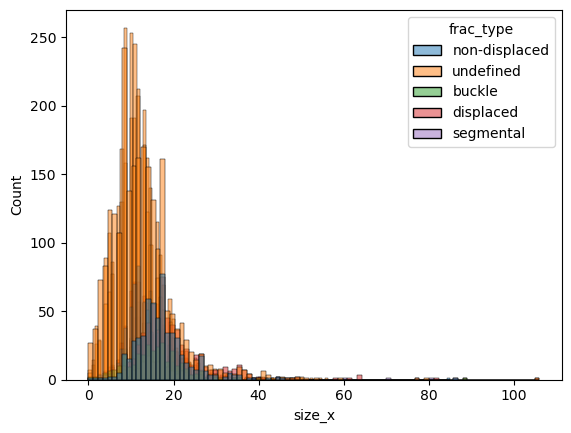

In [26]:
# src: https://seaborn.pydata.org/generated/seaborn.histplot.html
sns.histplot(data=data, x="size_x", hue="frac_type")
sns.histplot(data=data, x="size_y", hue="frac_type")
sns.histplot(data=data, x="size_z", hue="frac_type")